In [1]:
%matplotlib inline
import utils
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
import librosa
import librosa.display
import missingno as msno 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler, RobustScaler
# importing warning in order to ignore them
import warnings 
warnings.filterwarnings('always')   #suppresses all warnings
warnings.filterwarnings('ignore')

In [2]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

tracks= utils.load("/Users/david/Desktop/DM2 project/fma_metadata/tracks.csv")
genres= utils.load("/Users/david/Desktop/DM2 project/fma_metadata/genres.csv")
features= utils.load("/Users/david/Desktop/DM2 project/fma_metadata/features.csv")
echonest= utils.load("/Users/david/Desktop/DM2 project/fma_metadata/echonest.csv")

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [3]:
tracks_cut=['album','artist']
tracks.drop(tracks_cut,axis=1,inplace=True)
tracks.shape

(106574, 22)

In [4]:
tracks=tracks.droplevel(0,axis=1)

In [5]:
tracks_cut=['composer','comments', 'date_created','date_recorded',
            'license','number','title','language_code',
            'publisher', 'tags','information','lyricist','genres','genres_all',
            'favorites','listens','interest','bit_rate', 'duration']
tracks.drop(tracks_cut,axis=1,inplace=True)

In [6]:
df_target=features[['spectral_rolloff','spectral_centroid']]

In [7]:
df_target=df_target.droplevel(0,axis=1)

In [8]:
df_target.columns=['roll_kurtosis','roll_max','roll_mean','roll_median','roll_min','roll_skew','roll_std',
                   'centr_kurtosis','centr_max','centr_mean','centr_median','centr_min','centr_skew','centr_std']
                   
                   #'bandw_kurtosis','bandw_max','bandw_mean','bandw_median','bandw_min','bandw_skew','bandw_std']
df_target.head()

,roll_kurtosis,roll_max,roll_mean,roll_median,roll_min,roll_skew,roll_std,centr_kurtosis,centr_max,centr_mean,centr_median,centr_min,centr_skew,centr_std
track_id,,,,,,,,,,,,,,
2,0.840540,9410.009766,3267.804688,3143.847656,0.000000,0.347372,1300.729736,2.406808,5514.049805,1639.583252,1503.496704,0.000000,1.079815,719.770508
3,2.379145,10002.172852,3514.619629,3413.012695,0.000000,1.118952,1650.357788,3.519866,6288.426758,1763.012451,1517.993652,0.000000,1.652693,972.758423
5,-0.238572,9442.309570,2773.931885,2863.916016,0.000000,0.266975,1323.465210,1.322586,5648.614746,1292.958130,1186.514038,0.000000,0.937101,665.319275
10,3.619834,10056.005859,2603.491943,2002.587891,0.000000,1.800220,1524.401245,9.729688,5739.394531,1360.028687,1180.966797,0.000000,2.523783,668.700806
20,-0.744805,9496.142578,4201.346191,4166.674805,75.366211,0.160345,1495.297119,2.177669,5540.209961,1732.971802,1640.781128,123.611168,0.960959,481.929871


In [9]:
df=pd.merge(tracks,df_target, on='track_id')

In [10]:
df.drop(index=df[df.subset=='large'].index, inplace=True)

# Pre-processing

In [11]:
train = df.index[df['split'] == 'training']
val = df.index[df['split'] == 'validation']
test = df.index[df['split'] == 'test']

In [12]:
#copy dataframe
df_enc=df.copy()

In [13]:
df_enc

,split,subset,genre_top,roll_kurtosis,roll_max,roll_mean,roll_median,roll_min,roll_skew,roll_std,centr_kurtosis,centr_max,centr_mean,centr_median,centr_min,centr_skew,centr_std
track_id,,,,,,,,,,,,,,,,,
2,training,small,Hip-Hop,0.840540,9410.009766,3267.804688,3143.847656,0.000000,0.347372,1300.729736,2.406808,5514.049805,1639.583252,1503.496704,0.000000,1.079815,719.770508
3,training,medium,Hip-Hop,2.379145,10002.172852,3514.619629,3413.012695,0.000000,1.118952,1650.357788,3.519866,6288.426758,1763.012451,1517.993652,0.000000,1.652693,972.758423
5,training,small,Hip-Hop,-0.238572,9442.309570,2773.931885,2863.916016,0.000000,0.266975,1323.465210,1.322586,5648.614746,1292.958130,1186.514038,0.000000,0.937101,665.319275
10,training,small,Pop,3.619834,10056.005859,2603.491943,2002.587891,0.000000,1.800220,1524.401245,9.729688,5739.394531,1360.028687,1180.966797,0.000000,2.523783,668.700806
134,training,medium,Hip-Hop,0.488314,9442.309570,2462.616943,2099.487305,0.000000,0.750207,1406.506592,2.208298,5518.117188,1257.696289,1118.902588,0.000000,1.120293,718.104797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155297,training,medium,Instrumental,32.431602,9883.740234,1189.471436,1033.593750,204.565430,5.377576,1276.645996,55.303261,8601.571289,750.424744,636.640259,220.715759,7.249722,919.452454
155298,training,medium,Folk,7.010324,9991.406250,1504.343750,1313.525391,0.000000,2.150454,1135.410767,18.339352,6361.462402,770.230652,676.175720,0.000000,3.141982,449.027496
155306,training,medium,Folk,7.370663,9453.076172,1562.254517,1238.159180,193.798828,2.179922,1146.488037,10.664659,5597.755859,780.710510,650.279541,193.229736,2.397812,472.045807


In [14]:
le=LabelEncoder()
ple= preprocessing.LabelEncoder()
df_enc['genre_top']=le.fit_transform(df_enc['genre_top'])

In [15]:
df_enc['genre_top'].unique()

array([ 7, 12, 13,  6,  5, 10,  4,  9, 14,  0, 15,  2,  1, 11,  8,  3])

In [16]:
replace_values=[ 7, 12, 13,  6,  5, 10,  4,  9, 14,  0, 15,  2,  1,  8,  3]
df_enc['genre_top']=df_enc['genre_top'].replace(replace_values,0)
df_enc['genre_top']=df_enc['genre_top'].replace(11,1)

In [17]:
y_train = df_enc['genre_top'].loc[df_enc['split'] == 'training']
y_val = df_enc['genre_top'].loc[df_enc['split'] == 'validation']
y_test = df_enc['genre_top'].loc[df_enc['split'] == 'test']
y_train.shape, y_val.shape, y_test.shape

((19922,), (2505,), (2573,))

In [18]:
X=df_enc.drop('genre_top',axis=1)

In [19]:
X_train = X.loc[X['split'] == 'training']
X_val = X.loc[X['split'] == 'validation']
X_test = X.loc[X['split'] == 'test']
X_train.shape, X_val.shape, X_test.shape

((19922, 16), (2505, 16), (2573, 16))

In [20]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [21]:
cut_columns=['split','subset']
            #'roll_max','roll_mean','roll_median','roll_min','roll_skew','roll_std',
                   #'centr_kurtosis','centr_max','centr_mean','centr_median','centr_min','centr_skew','centr_std']
X_train.drop(cut_columns,axis=1,inplace=True)
X_val.drop(cut_columns,axis=1,inplace=True)
X_test.drop(cut_columns,axis=1,inplace=True)

# Outlier Detection

In [22]:
#task:rimuovere l'1% degli outliers:
outlier_fraction = 0.1
#andremo a cercare slamente l'1% degli outliers e li rimuoveremo o sostituiremo in seguito

### ABOD

In [23]:
from pyod.models.abod import ABOD

In [24]:
abod=ABOD(contamination=outlier_fraction)
abod.fit(X_train)

ABOD(contamination=0.1, method='fast', n_neighbors=5)

In [25]:
abod_anomalies = abod.predict(X_train)
np.unique(abod_anomalies, return_counts=True)

(array([0, 1]), array([17666,  2256], dtype=int64))

In [26]:
# select all rows that are not outliers
abod_inlier= abod_anomalies!=1
abod_outliers= X_train[abod_anomalies==1]
X_train.shape

(19922, 14)

In [27]:
# select all rows that are not outliers
abod_inlier= abod_anomalies!=1
abod_outlier= X_train[abod_anomalies==1]
X_train1, y_train1 = X_train.iloc[abod_inlier, :], y_train.iloc[abod_inlier]
# summarize the shape of the updated training dataset
print(X_train1.shape, y_train1.shape)

(17666, 14) (17666,)


### Isolation Forest

In [28]:
from sklearn.ensemble import IsolationForest

In [29]:
iso = IsolationForest(max_samples=100,random_state=42, contamination=0.1) 
iso.fit(X_train)
if_anomalies=iso.predict(X_train)

In [30]:
np.unique(if_anomalies,return_counts=True)

(array([-1,  1]), array([ 1993, 17929], dtype=int64))

In [31]:
# select all rows that are not outliers
if_inlier=if_anomalies!=-1
if_outlier=X_train[if_anomalies==-1]
X_train4, y_train4 = X_train.iloc[if_inlier, :], y_train.iloc[if_inlier]
# summarize the shape of the updated training dataset
print(X_train4.shape, y_train4.shape)

(17929, 14) (17929,)


### Comparison

In [32]:
if_indexes=if_outlier.index.tolist()
abod_indexes=abod_outlier.index.tolist()

In [33]:
#comparison if with abod
count_if_abod=0
for i in set(if_indexes).intersection(set(abod_indexes)):
    count_if_abod= count_if_abod+1
print(count_if_abod) 

743


In [34]:
X_train_clean=X_train.copy()
y_train_clean=y_train.copy()

In [35]:
for index in set(if_indexes).intersection(set(abod_indexes)):
    X_train_clean.drop(index,inplace=True)
    y_train_clean.drop(index, inplace=True)
print('Dataset before outliers removed:',X_train.shape, y_train.shape)
print('Dataset cleaned:', X_train_clean.shape, y_train_clean.shape)

Dataset before outliers removed: (19922, 14) (19922,)
Dataset cleaned: (19179, 14) (19179,)


In [36]:
X_train=X_train_clean
y_train=y_train_clean
X_train.shape,y_train.shape

((19179, 14), (19179,))

In [37]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

# Support Vector Machines

## Nonlinear SVM

In [40]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_params= {'C': [100.0,500.0, 1000.0],
              #'gamma': [0.00001, 0.001, 0.01, 0.1, 1, 10, 100], 
             'kernel': ['poly','rbf','sigmoid']}
gs= GridSearchCV(SVC(),
                grid_params,
                verbose=1,
                cv=5,
                n_jobs=-1)
gs_results=gs.fit(X_train,y_train)
gs_results.cv_results_.keys()

print(gs_results.best_score_,gs_results.best_params_)
report(gs_results.cv_results_, n_top=1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.9928046653334295 {'C': 1000.0, 'kernel': 'rbf'}
Mean validation score: 0.993 (std: 0.001)


In [210]:
from sklearn.svm import SVC
clf=SVC(C=1000.0, kernel='rbf',gamma='auto', random_state=42)
clf.fit(X_train,y_train)

SVC(C=1000.0, gamma='auto', random_state=42)

In [211]:
y_pred_val=clf.predict(X_val)

In [212]:
clf.support_

array([    0,     1,     2, ..., 18955, 19052, 19101])

In [213]:
clf.support_vectors_[:10]

array([[ 2.14424973e+01,  9.56074219e+03,  1.79032751e+03,
         1.57192383e+03,  0.00000000e+00,  4.56024504e+00,
         1.31740942e+03,  2.59521942e+01,  5.67784033e+03,
         9.29862915e+02,  8.18161804e+02,  0.00000000e+00,
         5.02569294e+00,  6.63488098e+02],
       [ 1.47545834e+01,  9.34541016e+03,  1.64957031e+03,
         1.61499023e+03,  4.41430664e+02,  2.52627540e+00,
         5.42584106e+02,  8.36458874e+00,  5.31285498e+03,
         9.32024048e+02,  9.09611755e+02,  3.19428009e+02,
         1.13995159e+00,  2.68295013e+02],
       [-1.27828157e+00,  6.04006348e+03,  2.78639917e+03,
         2.91774902e+03,  6.13696289e+02, -1.92570798e-02,
         1.13018909e+03, -7.72449732e-01,  2.86294043e+03,
         1.28863464e+03,  1.22540796e+03,  4.54283783e+02,
         4.01384234e-01,  5.02266693e+02],
       [ 5.35230219e-01,  9.00087891e+03,  2.06170190e+03,
         2.01335449e+03,  5.59863281e+02,  4.40245092e-01,
         6.42253662e+02,  1.50903502e+01,  5.

In [214]:
clf.n_support_, len(X_train)

(array([18770,   371]), 19179)

In [215]:
print('Accuracy {}'.format(accuracy_score(y_val,y_pred_val)))
print('F1-score {}'.format(f1_score(y_val,y_pred_val, average=None)))
print(classification_report(y_val,y_pred_val))
print(confusion_matrix(y_val,y_pred_val))  

Accuracy 0.9796407185628743
F1-score [0.98971567 0.        ]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2454
           1       0.00      0.00      0.00        51

    accuracy                           0.98      2505
   macro avg       0.49      0.50      0.49      2505
weighted avg       0.96      0.98      0.97      2505

[[2454    0]
 [  51    0]]


[[2454    0]
 [  51    0]]


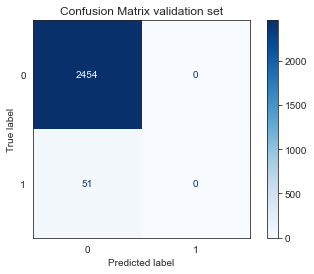

In [216]:
from sklearn.metrics import plot_confusion_matrix
sns.set_style('white')

disp = plot_confusion_matrix(clf,X_val,y_val,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix validation set')
print(disp.confusion_matrix)
plt.show()

In [217]:
fpr,tpr,_=roc_curve(y_val,y_pred_val)
roc_auc=auc(fpr,tpr)
print(roc_auc)

0.5


## Linear SVM

In [38]:
from sklearn.svm import LinearSVC

In [53]:
from sklearn.model_selection import GridSearchCV
grid_params= {'C':[0.001,10.0,20.0,30.0,40.0,50.0]}
gs= GridSearchCV(LinearSVC(),
                grid_params,
                verbose=1,
                cv=5,
                n_jobs=-1)
gs_results=gs.fit(X_train,y_train)
gs_results.cv_results_.keys()

print(gs_results.best_score_,gs_results.best_params_)
report(gs_results.cv_results_, n_top=1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.9892069912025374 {'C': 0.001}
Mean validation score: 0.989 (std: 0.001)


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_params= {'C':[60.0,70.0,80.0,90.0,100.0]}
gs= GridSearchCV(LinearSVC(),
                grid_params,
                verbose=1,
                cv=5,
                n_jobs=-1)
gs_results=gs.fit(X_train,y_train)
gs_results.cv_results_.keys()

print(gs_results.best_score_,gs_results.best_params_)
report(gs_results.cv_results_, n_top=1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.9891027023205672 {'C': 100.0}
Mean validation score: 0.989 (std: 0.001)


In [43]:
clf=LinearSVC(C=80.0,class_weight='balanced',loss="squared_hinge",random_state=42)
clf.fit(X_train, y_train)

LinearSVC(C=80.0, class_weight='balanced', random_state=42)

In [44]:
y_pred_val=clf.predict(X_val)

In [45]:
print('Accuracy %s' % accuracy_score(y_val,y_pred_val))
print('F1-score %s' % f1_score(y_val, y_pred_val,average=None))
print(classification_report(y_val,y_pred_val))
print(confusion_matrix(y_val, y_pred_val)) 

Accuracy 0.973253493013972
F1-score [0.98629016 0.45528455]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2454
           1       0.39      0.55      0.46        51

    accuracy                           0.97      2505
   macro avg       0.69      0.77      0.72      2505
weighted avg       0.98      0.97      0.98      2505

[[2410   44]
 [  23   28]]


[[2410   44]
 [  23   28]]


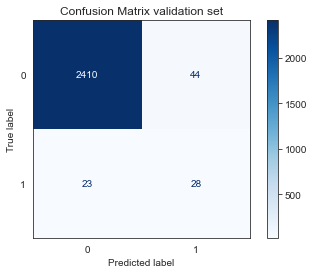

In [46]:
from sklearn.metrics import plot_confusion_matrix
sns.set_style('white')

disp = plot_confusion_matrix(clf,X_val,y_val,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix validation set')
print(disp.confusion_matrix)
plt.show()

In [47]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr,tpr,_=roc_curve(y_val,y_pred_val)
roc_auc=auc(fpr,tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_val, y_pred_val, average=None)

0.7655448487463445


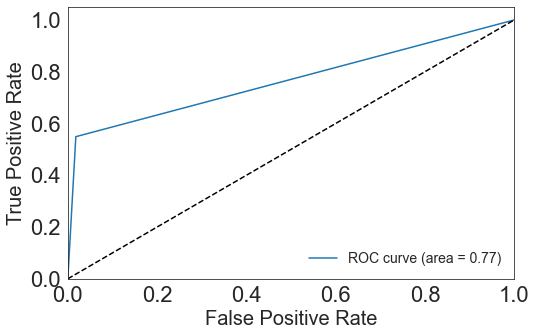

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [49]:
decision_function = clf.decision_function(X_train)
support_vector_indices =  np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = X_train.iloc[support_vector_indices]

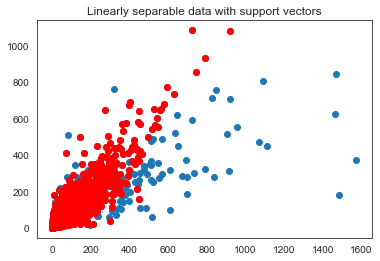

In [50]:
# Visualize support vectors
plt.scatter(X_train.iloc[:,0], X_train.iloc[:,7])
plt.scatter(support_vectors.iloc[:,0], support_vectors.iloc[:,7], color='red')
plt.title('Linearly separable data with support vectors')
#plt.xlabel('X1')
#plt.ylabel('X2')
plt.show()

## BLIND TEST

In [51]:
y_pred_test=clf.predict(X_test)

In [52]:
print('Accuracy test set',metrics.accuracy_score(y_test,y_pred_test))

Accuracy test set 0.9875631558492033


In [53]:
print('Accuracy %s' % accuracy_score(y_test,y_pred_test))
print('F1-score %s' % f1_score(y_test,y_pred_test,average=None))
print(classification_report(y_test,y_pred_test))
print(confusion_matrix(y_test,y_pred_test)) 

Accuracy 0.9875631558492033
F1-score [0.99364827 0.7037037 ]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2522
           1       0.67      0.75      0.70        51

    accuracy                           0.99      2573
   macro avg       0.83      0.87      0.85      2573
weighted avg       0.99      0.99      0.99      2573

[[2503   19]
 [  13   38]]


[[2503   19]
 [  13   38]]


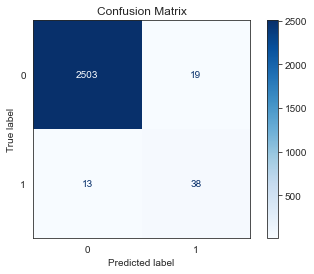

In [54]:
from sklearn.metrics import plot_confusion_matrix
sns.set_style('white')

disp = plot_confusion_matrix(clf,X_test,y_test,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix')
print(disp.confusion_matrix)
plt.show()

In [55]:
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)
print(roc_auc)

#metodo alternativo calcolare roc
roc_auc = roc_auc_score(y_test, y_pred_test, average=None)

0.8687821679028471


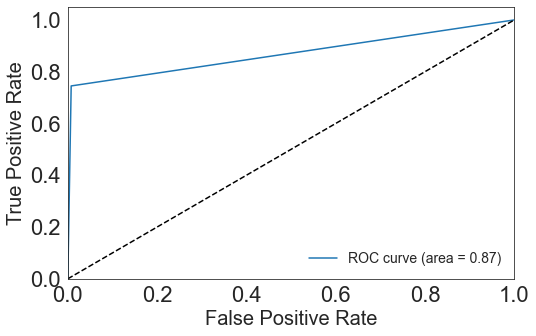

In [56]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

## Random Oversamling

In [57]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

In [58]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 18808, 1: 18808})


In [64]:
clf.fit(X_res, y_res)

y_pred_random = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

Accuracy 0.881849980567431
F1-score [0.93594606 0.24      ]
              precision    recall  f1-score   support

           0       1.00      0.88      0.94      2522
           1       0.14      0.94      0.24        51

    accuracy                           0.88      2573
   macro avg       0.57      0.91      0.59      2573
weighted avg       0.98      0.88      0.92      2573

[[2221  301]
 [   3   48]]


### CondenseNearestNeighbour

In [60]:
from imblearn.under_sampling import CondensedNearestNeighbour

In [61]:
cnn = CondensedNearestNeighbour(random_state=42, n_jobs=10)
X_res_cnn, y_res_cnn = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res_cnn))

Resampled dataset shape Counter({0: 585, 1: 371})


In [62]:
clf.fit(X_res_cnn, y_res_cnn)

dt_pred_cnn = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, dt_pred_cnn))
print('F1-score %s' % f1_score(y_test, dt_pred_cnn, average=None))
print(classification_report(y_test, dt_pred_cnn))
print(confusion_matrix(y_test,dt_pred_cnn))

Accuracy 0.9852312475709288
F1-score [0.99245133 0.66071429]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2522
           1       0.61      0.73      0.66        51

    accuracy                           0.99      2573
   macro avg       0.80      0.86      0.83      2573
weighted avg       0.99      0.99      0.99      2573

[[2498   24]
 [  14   37]]


In [65]:
fpr_random,tpr_random,_=roc_curve(y_test,y_pred_random)
roc_auc_random=auc(fpr_random,tpr_random)
print(roc_auc_random)

0.9109133740728647


In [66]:
fpr_cnn,tpr_cnn,_=roc_curve(y_test,dt_pred_cnn)
roc_auc_cnn=auc(fpr_cnn,tpr_cnn)
print(roc_auc_cnn)

0.8579869695697471


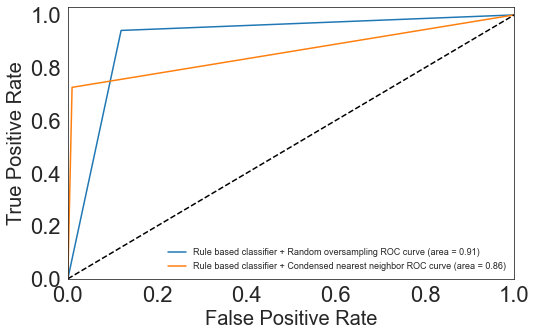

In [67]:
plt.figure(figsize=(8, 5))
plt.plot(fpr_random, tpr_random, label='Rule based classifier + Random oversampling ROC curve (area = %0.2f)' % (roc_auc_random))
plt.plot(fpr_cnn, tpr_cnn, label='Rule based classifier + Condensed nearest neighbor ROC curve (area = %0.2f)' % (roc_auc_cnn))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=9, frameon=False)
plt.show()